# This notebook is used to visualy inspect the quality of the ground truths and the proposed regions of interest RoI for the masked R-CNN

In [1]:
dataset_filepath = "/net/vdesk/data2/penchev/project_data/inspect-pipeline/"
images_train_filepath = "images"
proposals_train_filepath = "proposals"
annotations_path = "annotations.json"

# Load the json file containing the cutout metadata and proposed RoIs

In [2]:
import json
import os

annotations_path = os.path.join(dataset_filepath, annotations_path)
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Show the structure of the annotations (COCO format)
for key in annotations.keys():
    key_type = type(annotations[key])
    element_type = type(annotations[key][0]) if isinstance(annotations[key], list) and len(annotations[key]) > 0 else None
    print(f"{key}: {key_type}, element type: {element_type}, length: {len(annotations[key])}")
    if element_type == dict:
        for key2 in annotations[key][0].keys():
            key2_type = type(annotations[key][0][key2])
            element2_type = type(annotations[key][0][key2][0]) if isinstance(annotations[key][0][key2], list) and len(annotations[key][0][key2]) > 0 else None
            print(f"  {key2}: {key2_type}")
            if key2 == "metadata":
                for key3 in annotations[key][0][key2].keys():
                    key3_type = type(annotations[key][0][key2][key3])
                    print(f"    {key3}: {key3_type}")

images: <class 'list'>, element type: <class 'dict'>, length: 7877
  id: <class 'int'>
  file_name: <class 'str'>
  width: <class 'int'>
  height: <class 'int'>
  metadata: <class 'dict'>
    RA: <class 'float'>
    DEC: <class 'float'>
    grg_positions: <class 'list'>
    all_component_positions: <class 'list'>
    rotated: <class 'bool'>
    origin_id: <class 'int'>
    rotation_angle: <class 'int'>
    stretch: <class 'str'>
    reprojected: <class 'bool'>
    old_redshift: <class 'NoneType'>
    new_redshift: <class 'NoneType'>
annotations: <class 'list'>, element type: <class 'dict'>, length: 7877
  id: <class 'int'>
  image_id: <class 'int'>
  category_id: <class 'int'>
  bbox: <class 'list'>
  area: <class 'float'>
  segmentation: <class 'dict'>
  iscrowd: <class 'int'>
categories: <class 'list'>, element type: <class 'dict'>, length: 1
  id: <class 'int'>
  name: <class 'str'>


# Display the images with the proposed RoIs and ground truth annotations

In [ ]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np
import os

def get_image_by_id(annotations: dict, image_id: int) -> dict:
    """
    Retrieve the image element from the annotations JSON by image ID.
    
    :param annotations: The annotations dictionary containing 'images' list
    :param image_id: The ID of the image to find
    :return: Dictionary containing image metadata (id, file_name, width, height, metadata)
    :raises ValueError: If image_id is not found
    """
    for image in annotations['images']:
        if image['id'] == image_id:
            return image
    raise ValueError(f"Image with id {image_id} not found in annotations")

def plot_image_with_boxes_proposals(annotations: dict, annotations_path: str, id: int):
    """
    Plot an image with bounding boxes overlaid.
    
    :param image_path: Path to the image file
    :param boxes: Array of bounding boxes in the format [x_min, y_min, x_max, y_max]
    """
    image_info = get_image_by_id(annotations, id)
    image_file_name = image_info['file_name']
    proposals = image_file_name.replace(".png", ".npz")
    image_path = os.path.join(dataset_filepath, images_train_filepath, image_file_name)
    proposals_path = os.path.join(dataset_filepath, proposals_train_filepath, proposals)

    # Get the data for the plotting of the images
    proposal_boxes = np.load(proposals_path)['boxes']

    # Load COCO annotations
    coco = COCO(annotations_path)
    ann_ids = coco.getAnnIds(imgIds=[id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    # COCO format: [x_min, y_min, x_max, y_max]
    # (x_min, y_min) is the top-left corner
    # (x_max, y_max) is the bottom-right corner
    gt_boxes = [ann['bbox'] for ann in anns]
    
    # Get segmentation masks
    segs = [ann['segmentation'] for ann in anns]
    
    # Get component positions
    grg_positions = image_info['metadata'].get('grg_positions', [])
    all_component_positions = image_info['metadata'].get('all_component_positions', [])
    
    # Exclude GRG positions from all component positions
    comp_positions = [pos for pos in all_component_positions if pos not in grg_positions]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    img = plt.imread(image_path)
    
    # Plot GT boxes and segmentation on ax[0]
    ax[0].imshow(img)
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='blue', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    for seg in segs:
        if isinstance(seg, list):  # Polygon segmentation
            print(f"Polygon segmentation with {len(seg)} polygons")
            for polygon in seg:
                poly = np.array(polygon).reshape((-1, 2))
                ax[0].fill(poly[:, 0], poly[:, 1], alpha=0.3, color='black')
        if isinstance(seg, dict) and 'counts' in seg:  # RLE segmentation
            print("RLE segmentation found")
            mask = coco.annToMask(anns[0])  # Get binary mask from RLE
            # Plot the mask as a semi-transparent overlay (excluding background)
            masked = np.ma.masked_where(mask == 0, mask)
            ax[0].imshow(masked, alpha=1, cmap='Oranges', interpolation='none')
    for pos in grg_positions:
        x, y = pos
        ax[0].scatter(x, y, c='red', s=10)
        ax[0].annotate(f"({x:.1f}, {y:.1f})", (x, y), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=8)
    for pos in comp_positions:
        x, y = pos
        ax[0].scatter(x, y, c='cyan', s=10)
        ax[0].annotate(f"({x:.1f}, {y:.1f})", (x, y), textcoords="offset points", xytext=(0,5), ha='center', color='cyan', fontsize=8)
    
    ax[0].set_title("GT Boxes and Segmentation")

    ax[1].imshow(img)
    print(f"Plotting {len(proposal_boxes)} proposal boxes on image {image_file_name}")

    # First find the box with the biggest overlap with GT boxes
    iou_scores = []
    gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_boxes[0]  # Assuming one GT box for simplicity
    gt_width = gt_x_max - gt_x_min
    gt_height = gt_y_max - gt_y_min
    gt_box_area = gt_width * gt_height
    # assert gt_width > 0, "GT box has non-positive width"
    # assert gt_height > 0, "GT box has non-positive height"
    for box in proposal_boxes:
        # Get the proposal box coordinates
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Calculate intersection
        inter_x_min = max(x_min, gt_x_min)
        inter_y_min = max(y_min, gt_y_min)
        inter_x_max = min(x_max, gt_x_max)
        inter_y_max = min(y_max, gt_y_max)
        inter_width = max(0, inter_x_max - inter_x_min)
        inter_height = max(0, inter_y_max - inter_y_min)
        intersection = inter_width * inter_height

        # Calculate union
        box_area = width * height
        union = box_area + gt_box_area - intersection
        iou = intersection / union if union > 0 else 0

        iou_scores.append(iou)

    iou_scores_arr = np.array(iou_scores)
    best_box_idx = np.argmax(iou_scores_arr)
    print(f"Best box index: {best_box_idx}, IoU: {iou_scores_arr[best_box_idx]:.4f}")

    for i, box in enumerate(proposal_boxes):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2, label='Proposed Box' if i == 0 else "")
        ax[1].add_patch(rect)

    # Plot the best box in green
    best_box = proposal_boxes[best_box_idx]
    x_min, y_min, x_max, y_max = best_box
    width = x_max - x_min
    height = y_max - y_min
    rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='green', facecolor='none', linewidth=2, label='Best Box')
    ax[1].add_patch(rect)

    ax[1].set_title("Image with Bounding Boxes")
    plt.legend()
    plt.show()

First proposal box (raw): [124. 109. 176. 192.]
Proposal box shape: (127, 4)
loading annotations into memory...


Done (t=0.57s)
creating index...
index created!
RLE segmentation found
Plotting 127 proposal boxes on image LoTSS_GRG_0000003354_RA130.3670977_DEC28.76613679388.png
Best box index: 0, IoU: 1.0000


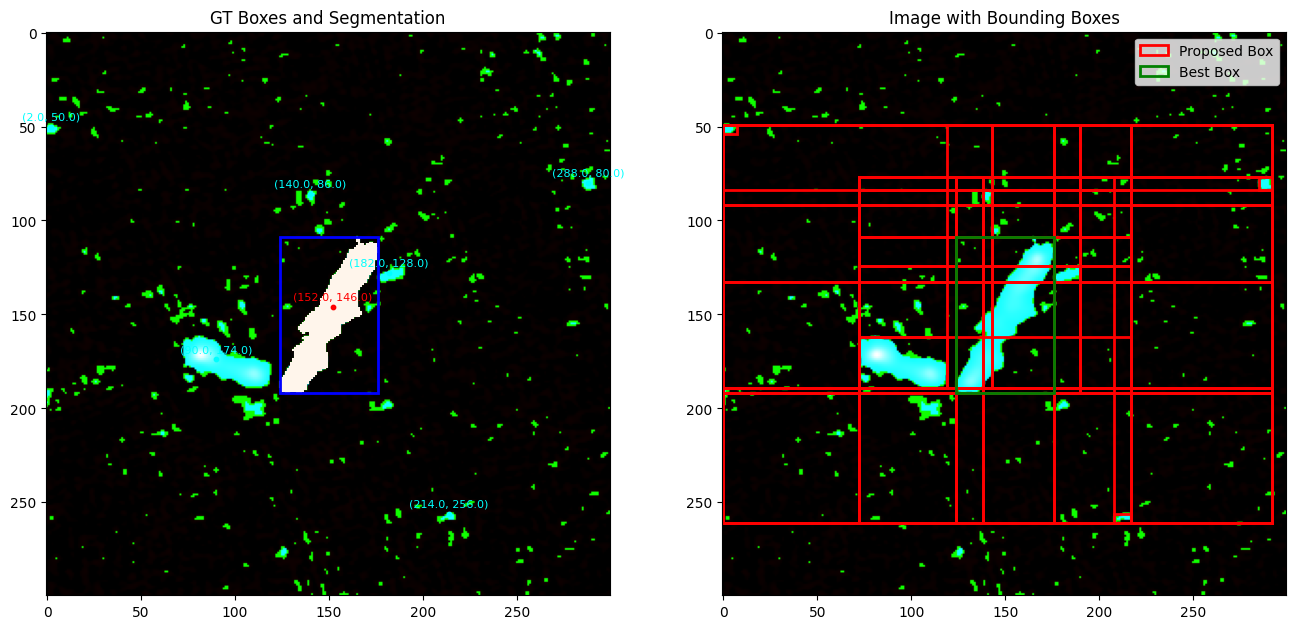

First proposal box (raw): [100.  91. 207. 212.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
RLE segmentation found
Plotting 511 proposal boxes on image LoTSS_GRG_0000005571_RA156.17952377289_DEC36.78917973659.png
Best box index: 0, IoU: 1.0000


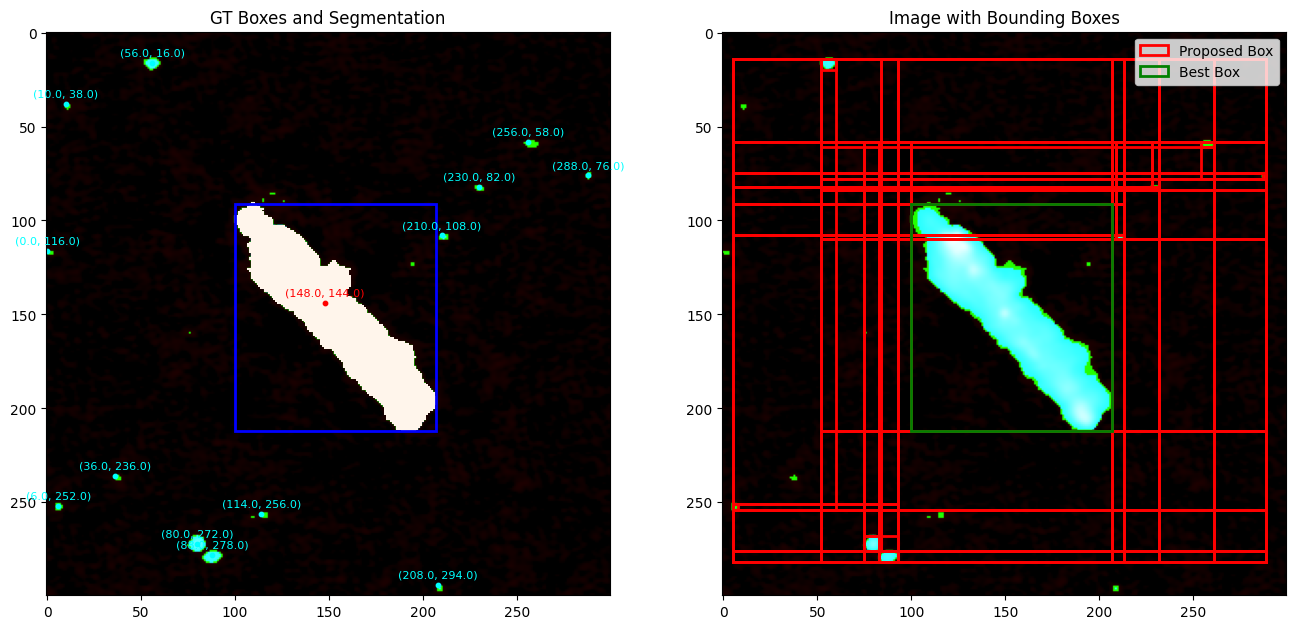

First proposal box (raw): [166. 131. 202. 167.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
RLE segmentation found
Plotting 1023 proposal boxes on image LoTSS_GRG_0000002519_rotated_angle315_RA13.0336991_DEC29.01161385388.png
Best box index: 10, IoU: 1.0000


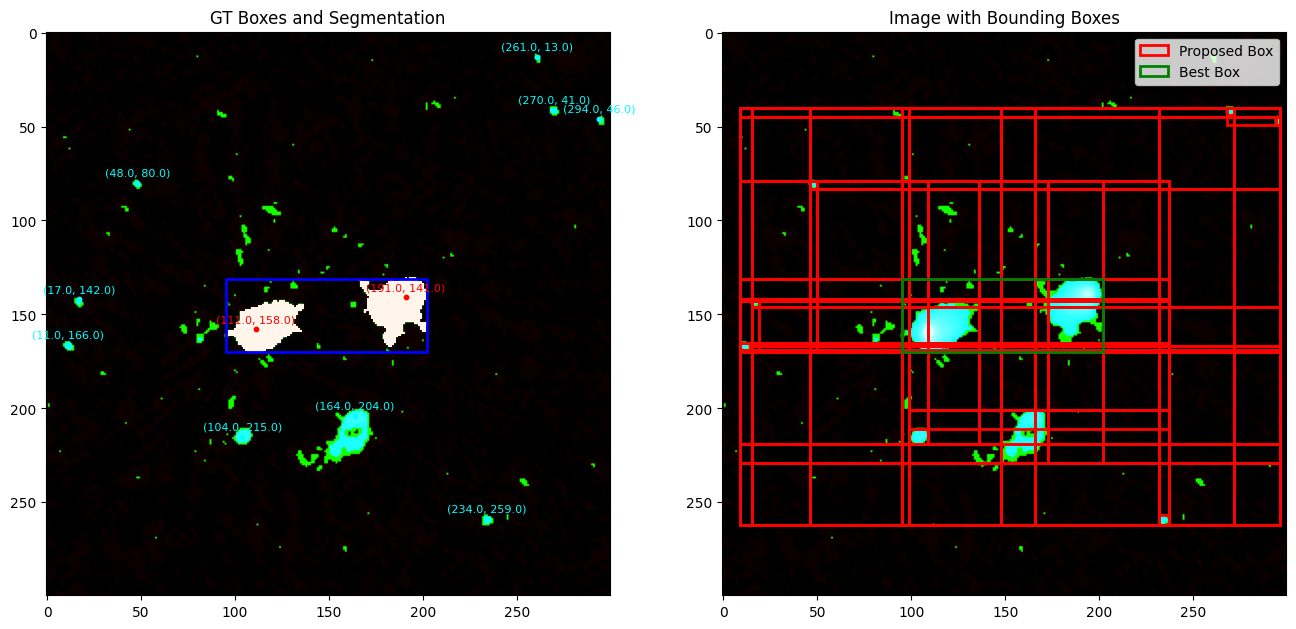

First proposal box (raw): [128.  92. 163. 201.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
RLE segmentation found
Plotting 1023 proposal boxes on image LoTSS_GRG_0000005758_rotated_angle45_RA158.856771_DEC37.74485985263.png
Best box index: 0, IoU: 1.0000


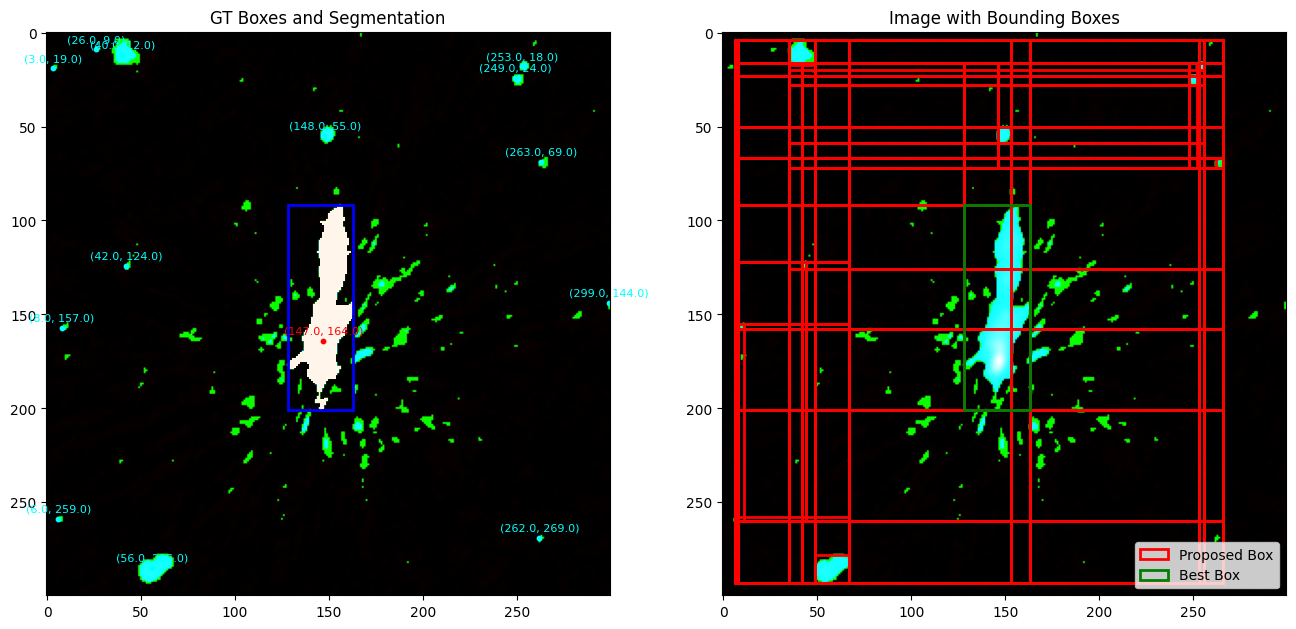

First proposal box (raw): [125. 108. 173. 205.]
Proposal box shape: (255, 4)
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
RLE segmentation found
Plotting 255 proposal boxes on image LoTSS_GRG_0000006499_rotated_angle45_RA168.142171_DEC41.00085344026.png
Best box index: 0, IoU: 1.0000


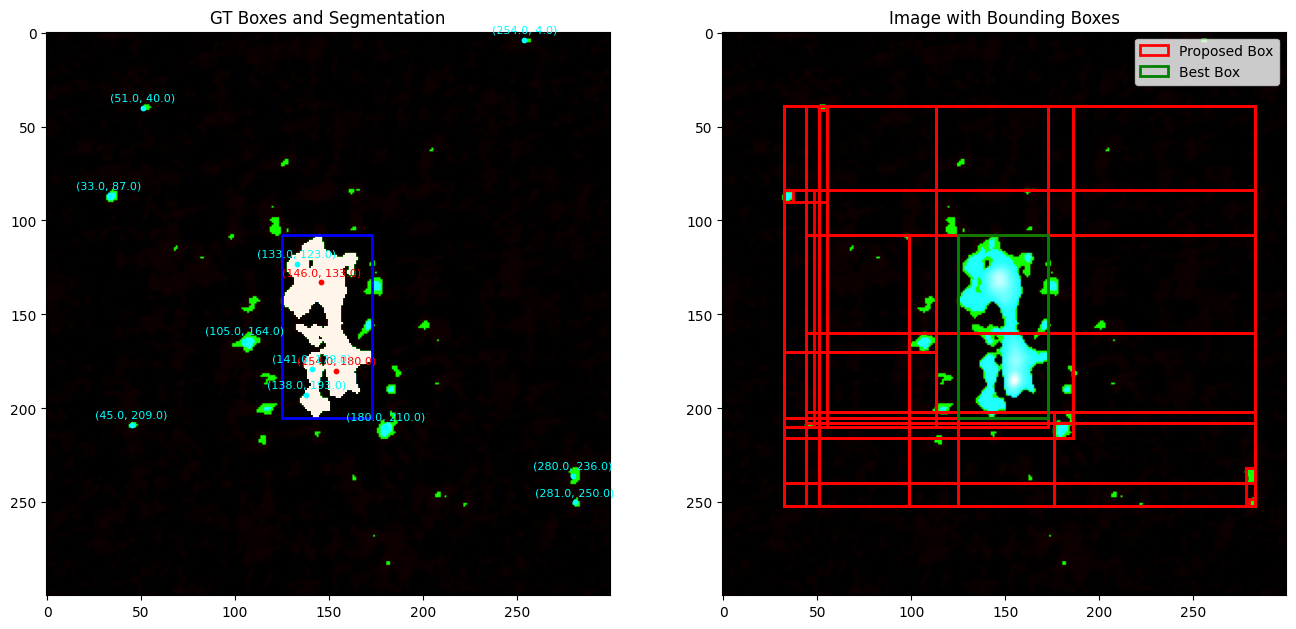

First proposal box (raw): [129. 120. 167. 188.]
Proposal box shape: (31, 4)
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
RLE segmentation found
Plotting 31 proposal boxes on image LoTSS_GRG_0000003754_rotated_angle315_RA127.2705324_DEC32.14982717852.png
Best box index: 0, IoU: 1.0000


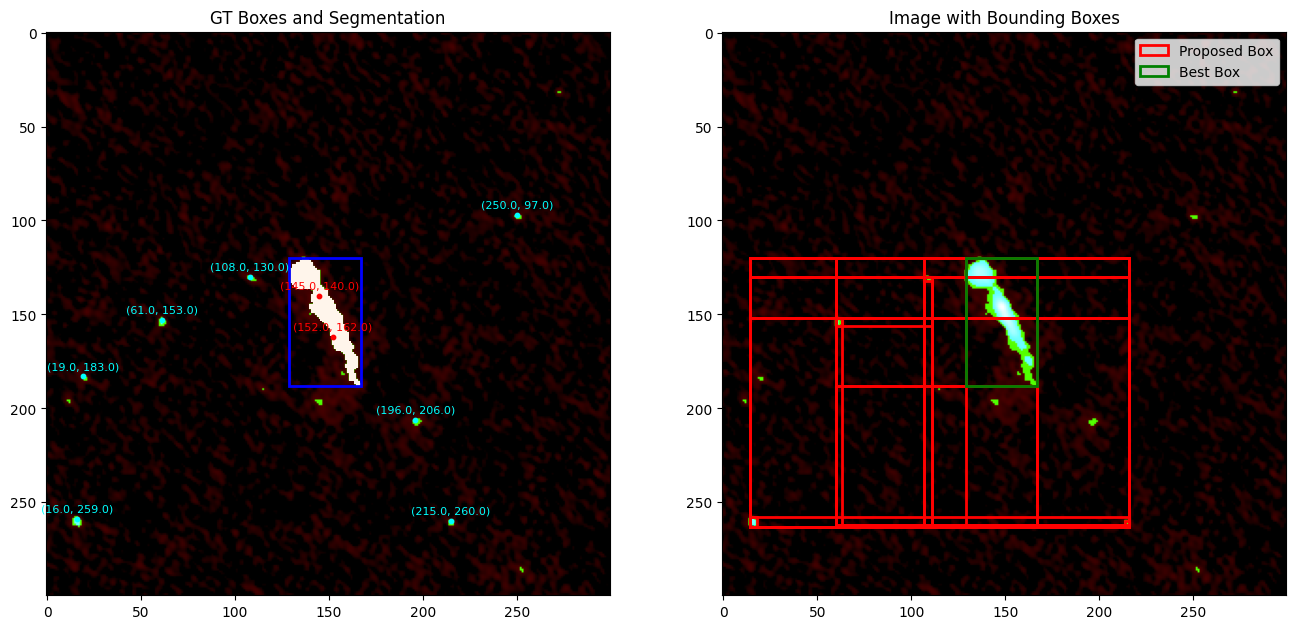

First proposal box (raw): [139. 118. 168. 179.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
RLE segmentation found
Plotting 511 proposal boxes on image LoTSS_GRG_0000003152_rotated_angle315_RA145.27583968618_DEC30.45916326564.png
Best box index: 0, IoU: 1.0000


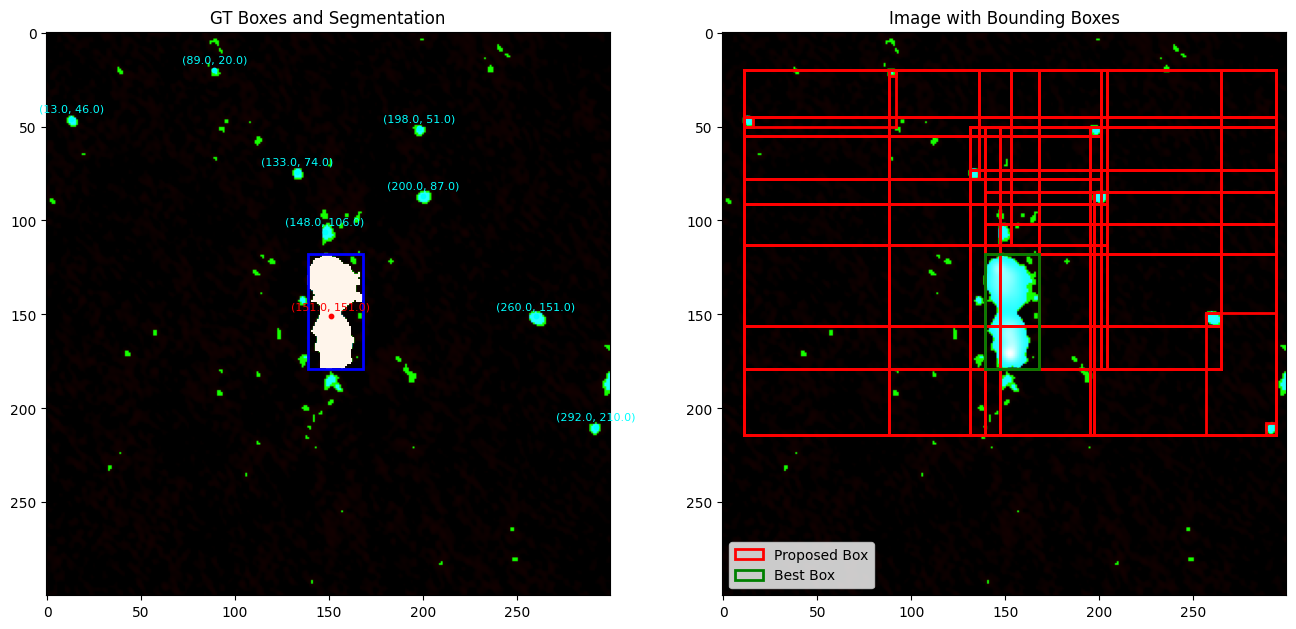

First proposal box (raw): [ 71. 115. 256. 204.]
Proposal box shape: (127, 4)
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
RLE segmentation found
Plotting 127 proposal boxes on image LoTSS_GRG_0000001730_RA28.397413_DEC33.47951600066.png
Best box index: 0, IoU: 1.0000


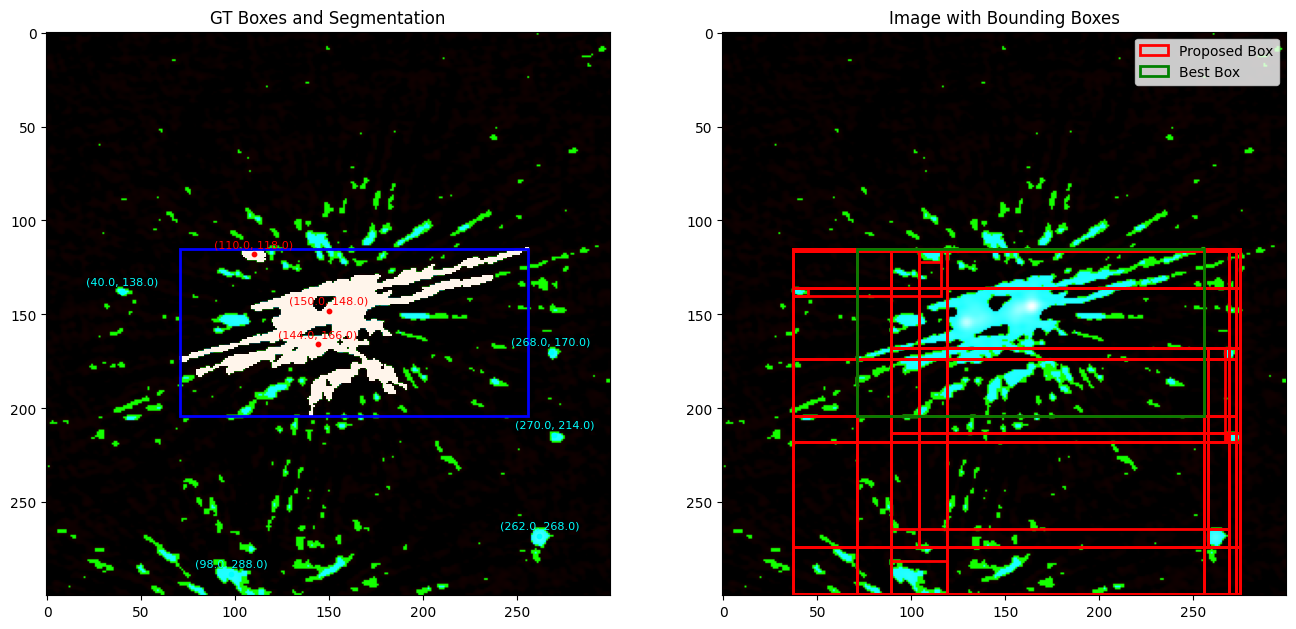

In [5]:
# Generate 8 random numbers from 0-7000
import random
random_ids = random.sample(range(7000), 8)
for i in random_ids:
    plot_image_with_boxes_proposals(annotations, annotations_path, i)

# Verify we have as many annotations as images

In [6]:
images = annotations['images']
annotations_list = annotations['annotations']
categories = annotations['categories']

print(f"Total images: {len(images)}")
print(f"Total annotations: {len(annotations_list)}")
print(f"Categories: {categories}")

Total images: 7877
Total annotations: 7877
Categories: [{'id': 1, 'name': 'GRG'}]


# Now we can explore the number of GRG components as well as the number of radio components per cutout. This is important metadata as we use this to evaluate our models

In [7]:
def explore_dataset(annotations: dict):
    grg_component_counts = []
    all_compoenent_counts = []
    for image in annotations['images']:
        grg_component_counts.append(len(image["metadata"]["grg_positions"]))
        all_compoenent_counts.append(len(image["metadata"]["all_component_positions"]))
    
    grg_component_counts_array = np.array(grg_component_counts)
    all_compoenent_counts_array =  np.array(all_compoenent_counts)

    # Get the minimum
    grg_min = np.min(grg_component_counts_array)
    all_min = np.min(all_compoenent_counts_array)
    
    # How many images have min components
    grg_min_count = np.sum(grg_component_counts_array == grg_min)
    all_min_count = np.sum(all_compoenent_counts_array == all_min)

    print(f"GRG Components - Min: {grg_min}, Count of images with min: {grg_min_count}")
    print(f"All Components - Min: {all_min}, Count of images with min: {all_min_count}")
    
    # Make a histogram of the counts
    import matplotlib.pyplot as plt
    plt.hist(grg_component_counts, bins=np.arange(0, max(grg_component_counts)+2)-0.5, edgecolor='black')
    plt.xlabel("Number of GRG Components per Image")
    plt.ylabel("Number of Images")
    plt.title("Distribution of GRG Components in Dataset")
    plt.show()

    plt.hist(all_compoenent_counts, bins=np.arange(0, max(all_compoenent_counts)+2)-0.5, edgecolor='black')
    plt.xlabel("Number of All Components per Image")
    plt.ylabel("Number of Images")
    plt.title("Distribution of All Components in Dataset")
    plt.show()

GRG Components - Min: 1, Count of images with min: 1905
All Components - Min: 2, Count of images with min: 40


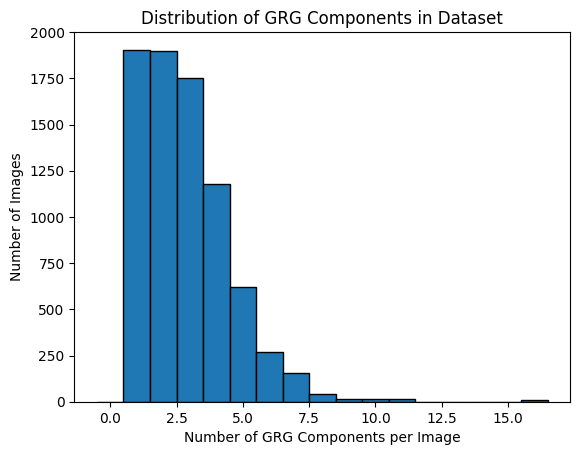

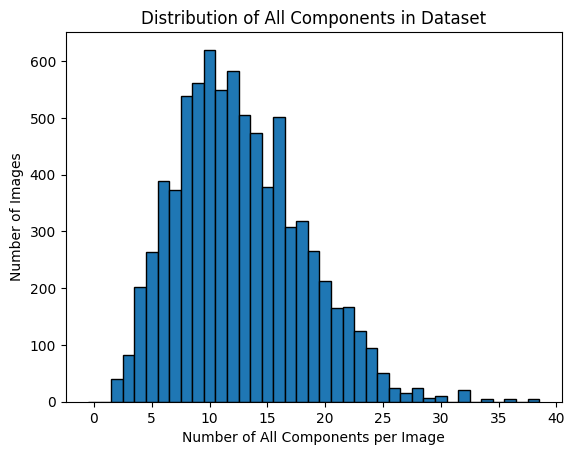

In [8]:
explore_dataset(annotations)

# Check evaluation procedure for the model against ground truth

In [9]:
import sys
sys.path.append("/home/penchev/astro-datatools/")
sys.path.append("/home/penchev/astro-datatools/projects/")
from grg_detection.coco.evaluator import GTEvaluator
from grg_detection.coco.clean import COCODatasetCleaner

In [10]:
evaluator = GTEvaluator(annotations, annotations_path)
results = evaluator.evaluate()

print("Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Evaluation Results:
accuracy: 0.6612
precision: 0.7698
recall: 0.8241


# We see that our procedure does NOT result in perferct score even from the ground truths. We need to clean up the unrelated components from the metadata. This is due to the fact that the dataset is not perfect and contains some unrelated radio components. We will use the COCODatasetCleaner to do this. After cleaning, we will re-evaluate the ground truths and see what we get.

In [11]:
cleaner = COCODatasetCleaner(annotations, annotations_path)
cleaned_annotations, cleaned_annotations_path, updated_images_ids, removed_images_ids = cleaner.clean(save_cleaned_dataset=False)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


# We compare the difference in GRG components before and after cleaning

1294 images were updated with cleaned annotations.
0 images were removed from the dataset due to having no GRG components after cleaning.


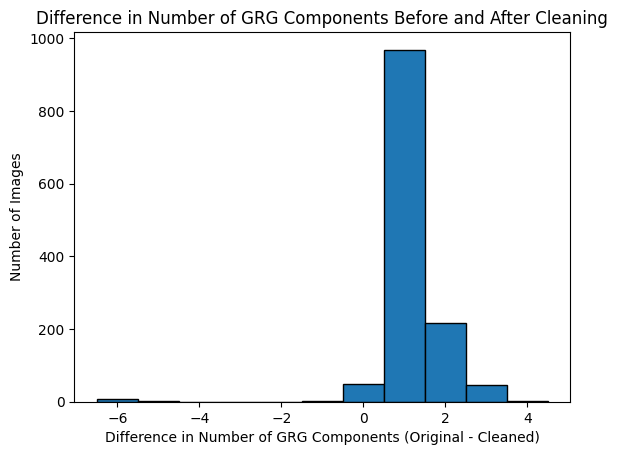

In [12]:
print(len(updated_images_ids), "images were updated with cleaned annotations.")
print(len(removed_images_ids), "images were removed from the dataset due to having no GRG components after cleaning.")

def compare_nr_of_grg_components_before_and_after_cleaning(annotations: dict, cleaned_annotations: dict, updated_images_ids: list):
    original_grg_numbers = []
    cleaned_grg_numbers = []
    for image in annotations['images']:
        if image['id'] in updated_images_ids:
            original_grg_components = image['metadata'].get('grg_positions', [])
            cleaned_image = next(img for img in cleaned_annotations['images'] if img['id'] == image['id'])
            cleaned_grg_components = cleaned_image['metadata'].get('grg_positions', [])
            original_grg_numbers.append(len(original_grg_components))
            cleaned_grg_numbers.append(len(cleaned_grg_components))

    or_grg = np.array(original_grg_numbers)
    cl_grg = np.array(cleaned_grg_numbers)

    diff_grg = or_grg - cl_grg

    plt.hist(diff_grg, bins=np.arange(min(diff_grg), max(diff_grg)+2)-0.5, edgecolor='black')
    plt.xlabel("Difference in Number of GRG Components (Original - Cleaned)")
    plt.ylabel("Number of Images")
    plt.title("Difference in Number of GRG Components Before and After Cleaning")
    plt.show()

compare_nr_of_grg_components_before_and_after_cleaning(annotations, cleaned_annotations, updated_images_ids)

We see that in this specific case the cleaner usually removed components that were not part of the GRG as evident by the fact that most 

$N_{original}-N_{cleaned}$

values are positive. Meaning that the cleaned dataset has less GRG components than the original one, likely becouse some components were outside the segmentation masks due to them being in a low surface brightness area.

# Let's evaluate the cleaned dataset to confirm we get a perfect score now

In [13]:
evaluator = GTEvaluator(cleaned_annotations, annotations_path)
results = evaluator.evaluate()

print("Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
Evaluation Results:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000


We can see now that we get a perfect score on all metrics. Lets visualize the same images as before and see the difference. We should see that the unrelated radio components are now assigned to the background category and the components that are part of the GRG are assigned to the foreground category.

First proposal box (raw): [124. 109. 176. 192.]
Proposal box shape: (127, 4)
loading annotations into memory...


Done (t=1.02s)
creating index...
index created!
RLE segmentation found
Plotting 127 proposal boxes on image LoTSS_GRG_0000003354_RA130.3670977_DEC28.76613679388.png
Best box index: 0, IoU: 1.0000


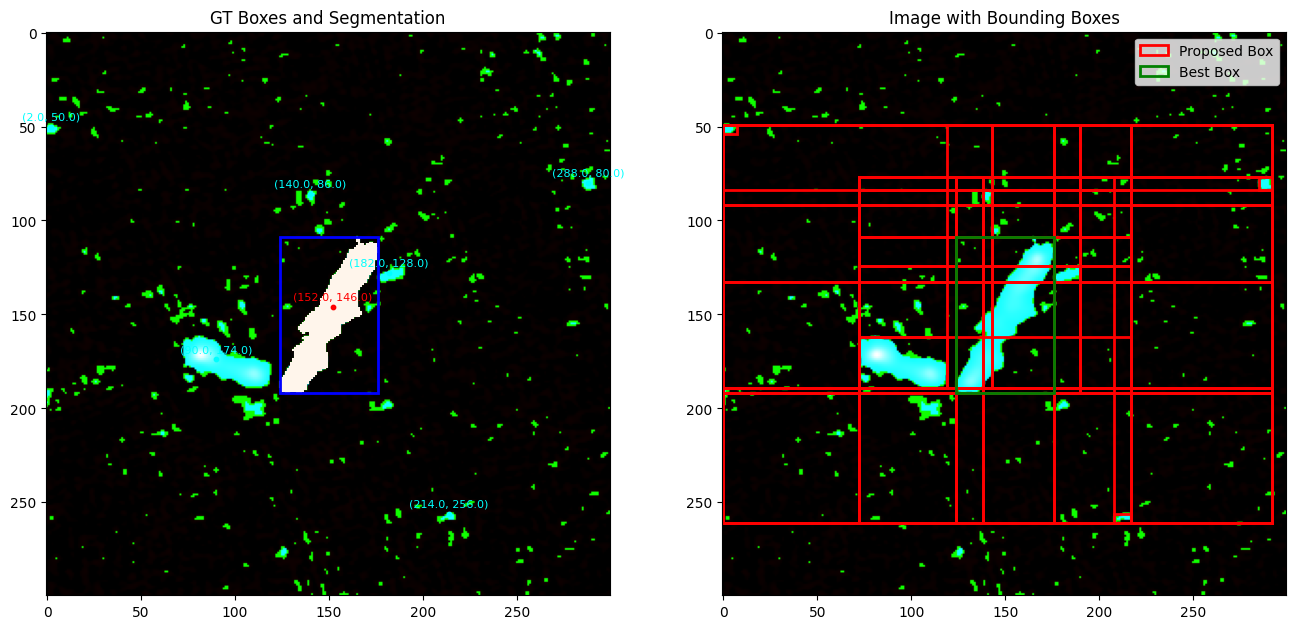

First proposal box (raw): [100.  91. 207. 212.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
RLE segmentation found
Plotting 511 proposal boxes on image LoTSS_GRG_0000005571_RA156.17952377289_DEC36.78917973659.png
Best box index: 0, IoU: 1.0000


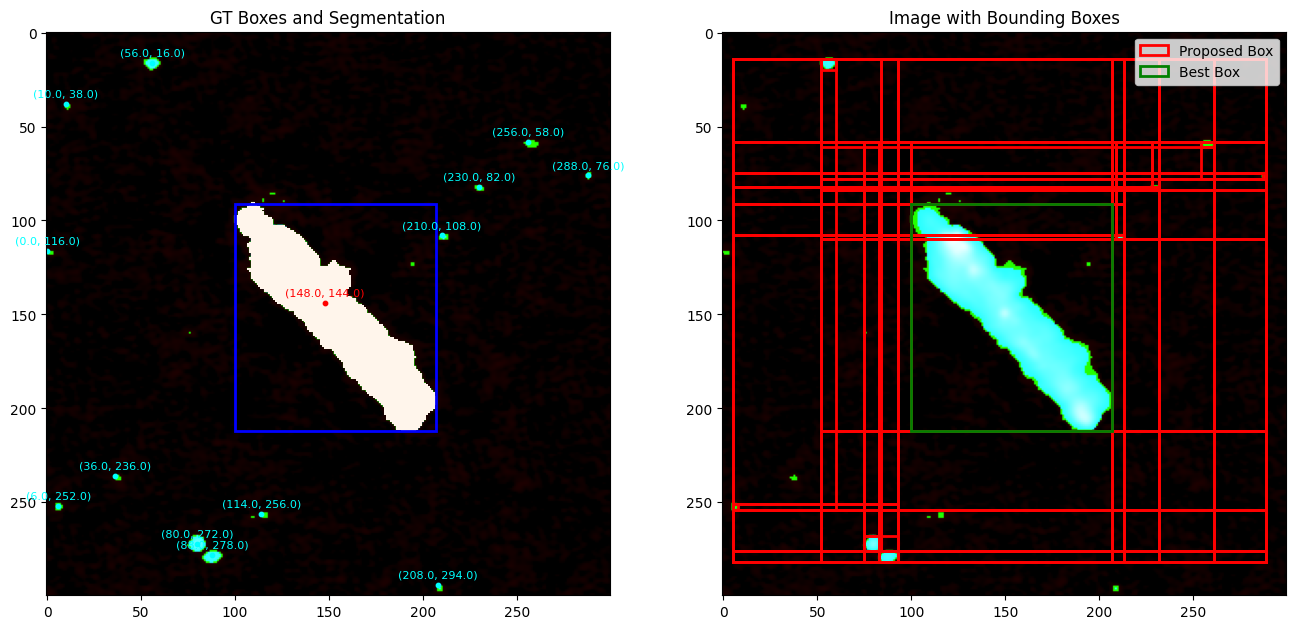

First proposal box (raw): [166. 131. 202. 167.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
RLE segmentation found
Plotting 1023 proposal boxes on image LoTSS_GRG_0000002519_rotated_angle315_RA13.0336991_DEC29.01161385388.png
Best box index: 10, IoU: 1.0000


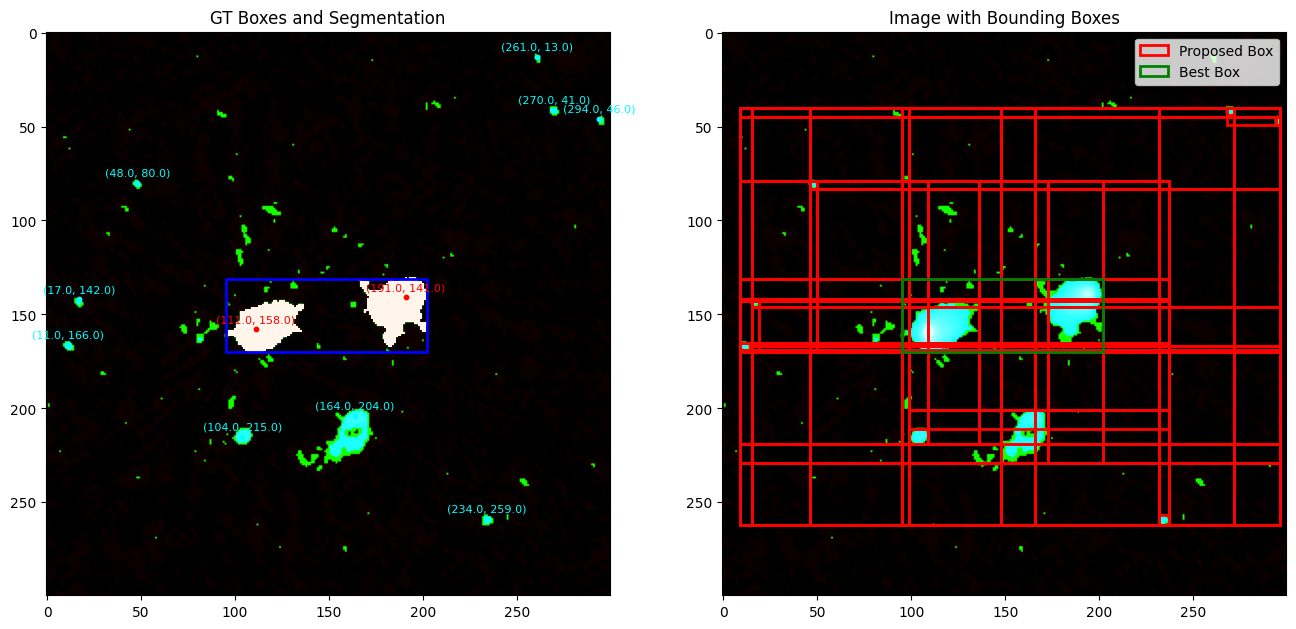

First proposal box (raw): [128.  92. 163. 201.]
Proposal box shape: (1023, 4)
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
RLE segmentation found
Plotting 1023 proposal boxes on image LoTSS_GRG_0000005758_rotated_angle45_RA158.856771_DEC37.74485985263.png
Best box index: 0, IoU: 1.0000


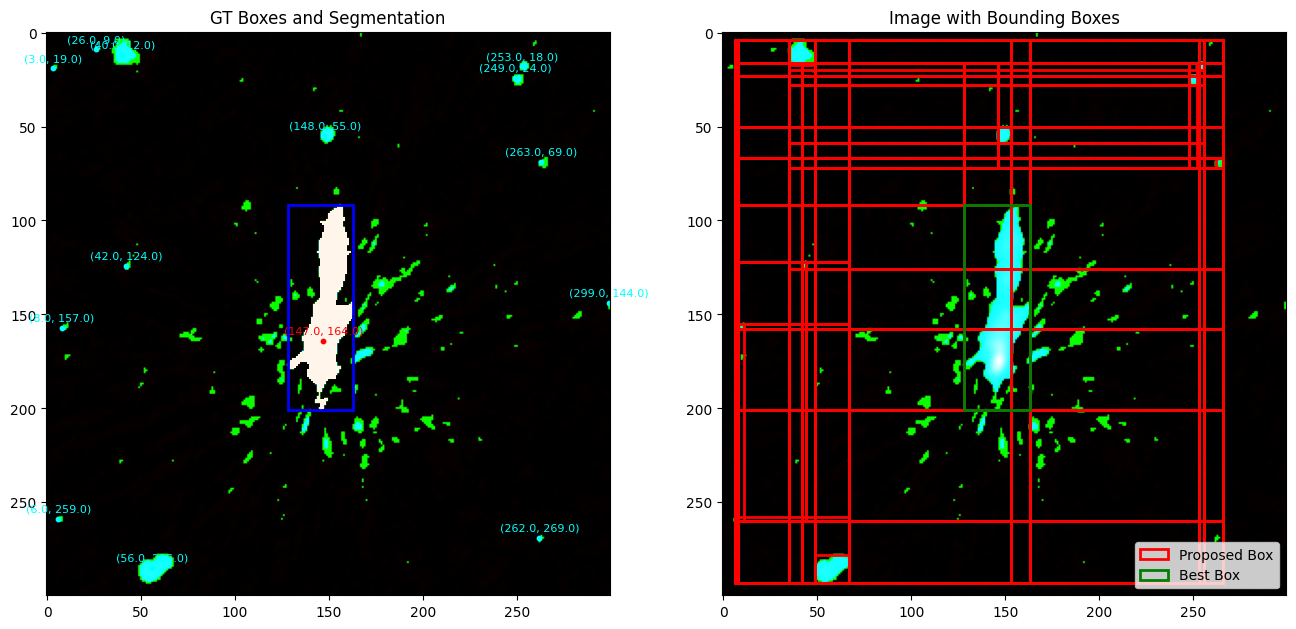

First proposal box (raw): [125. 108. 173. 205.]
Proposal box shape: (255, 4)
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
RLE segmentation found
Plotting 255 proposal boxes on image LoTSS_GRG_0000006499_rotated_angle45_RA168.142171_DEC41.00085344026.png
Best box index: 0, IoU: 1.0000


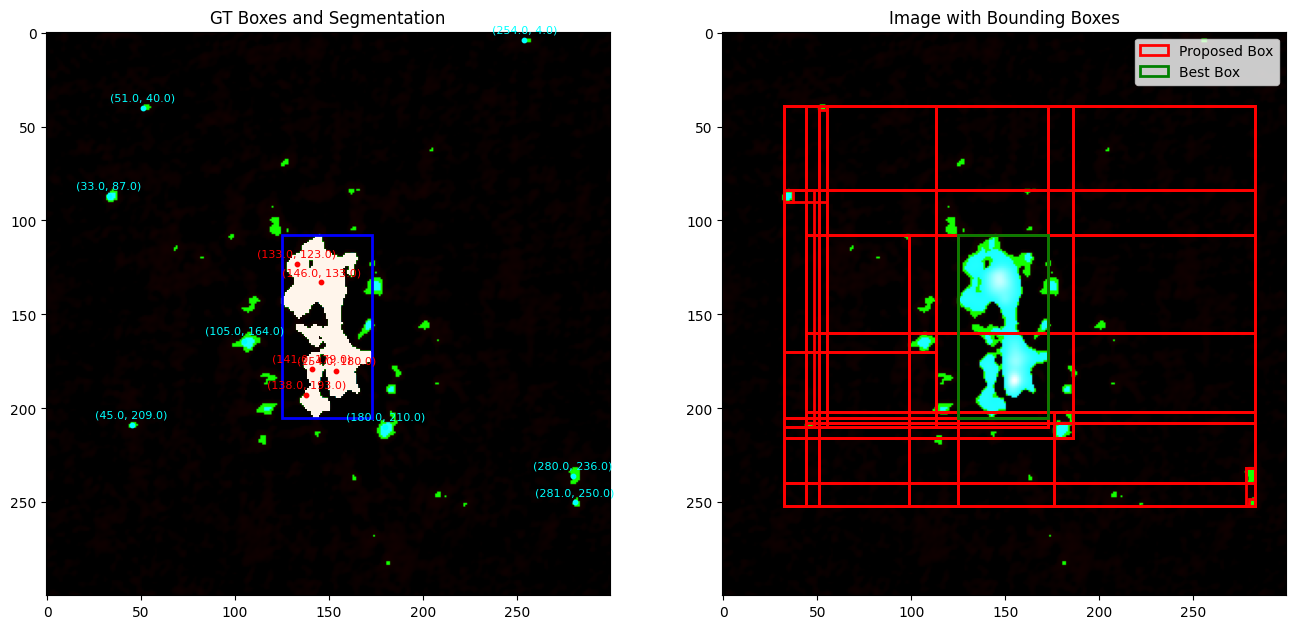

First proposal box (raw): [129. 120. 167. 188.]
Proposal box shape: (31, 4)
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
RLE segmentation found
Plotting 31 proposal boxes on image LoTSS_GRG_0000003754_rotated_angle315_RA127.2705324_DEC32.14982717852.png
Best box index: 0, IoU: 1.0000


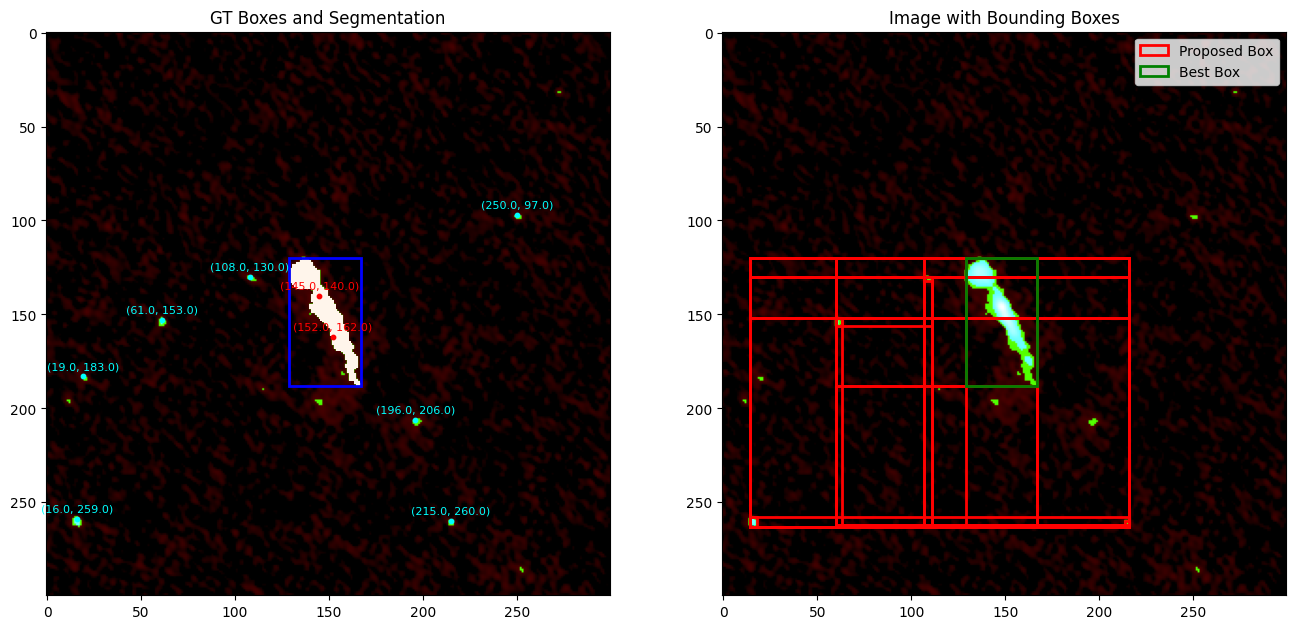

First proposal box (raw): [139. 118. 168. 179.]
Proposal box shape: (511, 4)
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
RLE segmentation found
Plotting 511 proposal boxes on image LoTSS_GRG_0000003152_rotated_angle315_RA145.27583968618_DEC30.45916326564.png
Best box index: 0, IoU: 1.0000


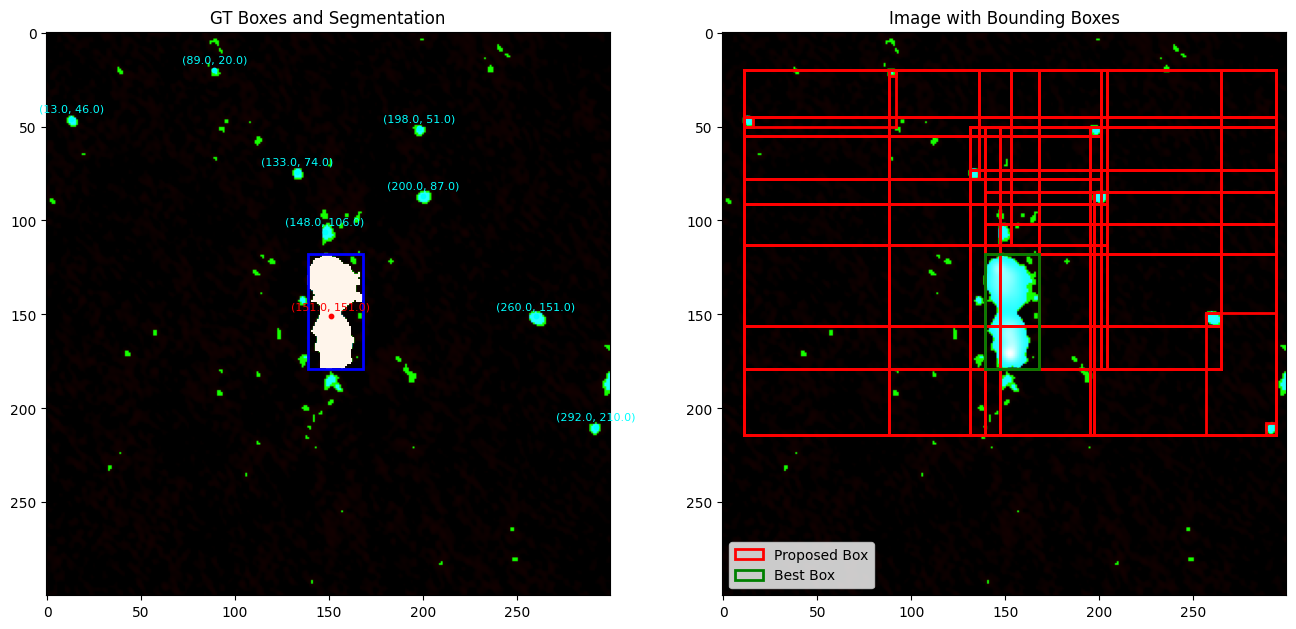

First proposal box (raw): [ 71. 115. 256. 204.]
Proposal box shape: (127, 4)
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
RLE segmentation found
Plotting 127 proposal boxes on image LoTSS_GRG_0000001730_RA28.397413_DEC33.47951600066.png
Best box index: 0, IoU: 1.0000


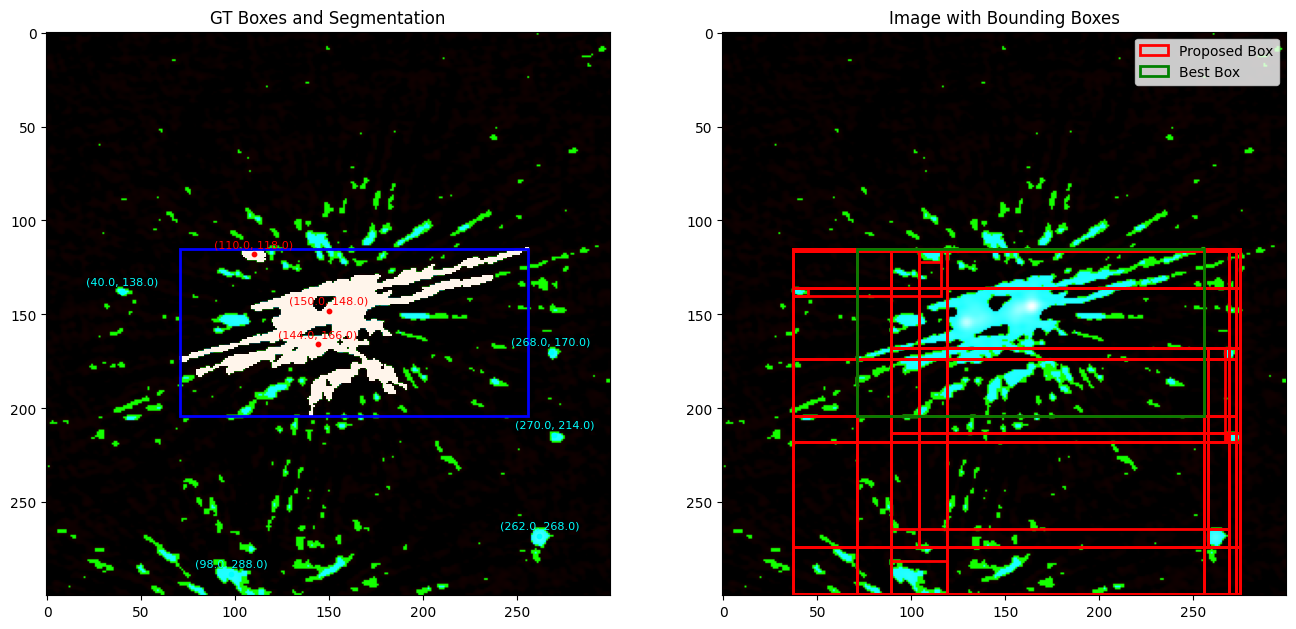

In [14]:
for i in random_ids:
    plot_image_with_boxes_proposals(cleaned_annotations, annotations_path, i)